RadioButtons(description='Plasma type:', options=('Argon and electrons', 'Neon and electrons', 'Helium and ele…

Text(value='')

<IPython.core.display.Javascript object>


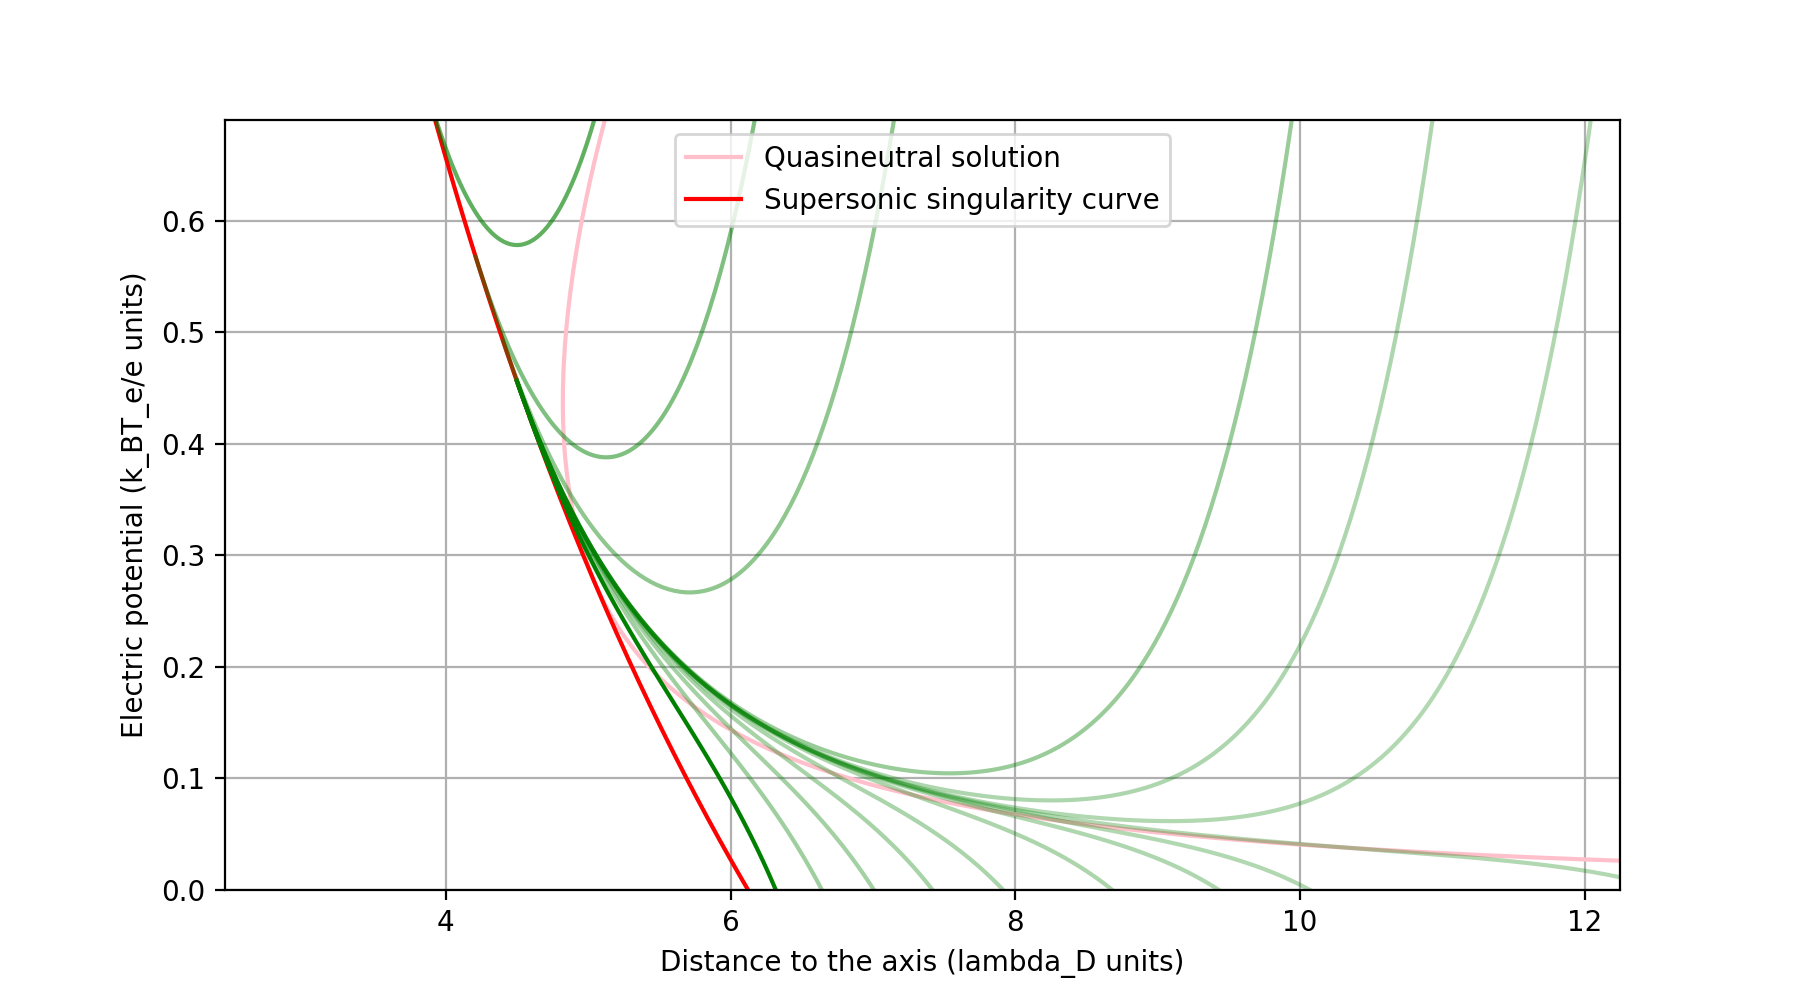

<IPython.core.display.Javascript object>


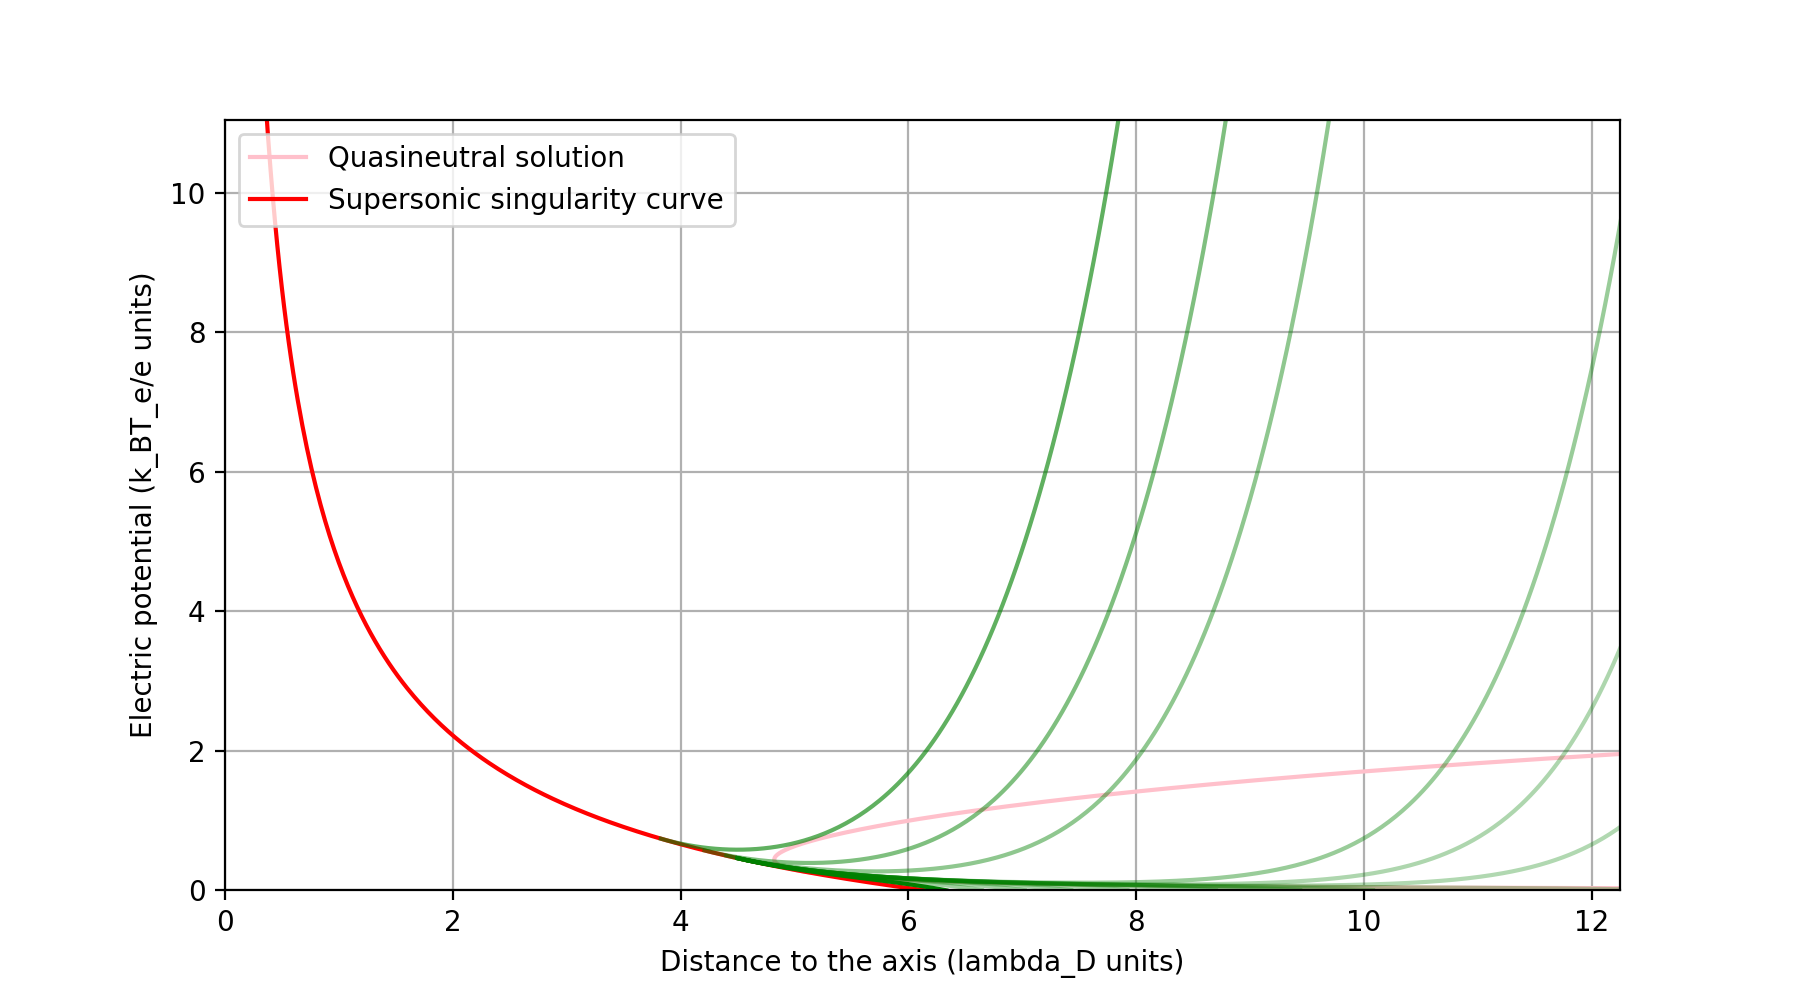

<IPython.core.display.Javascript object>


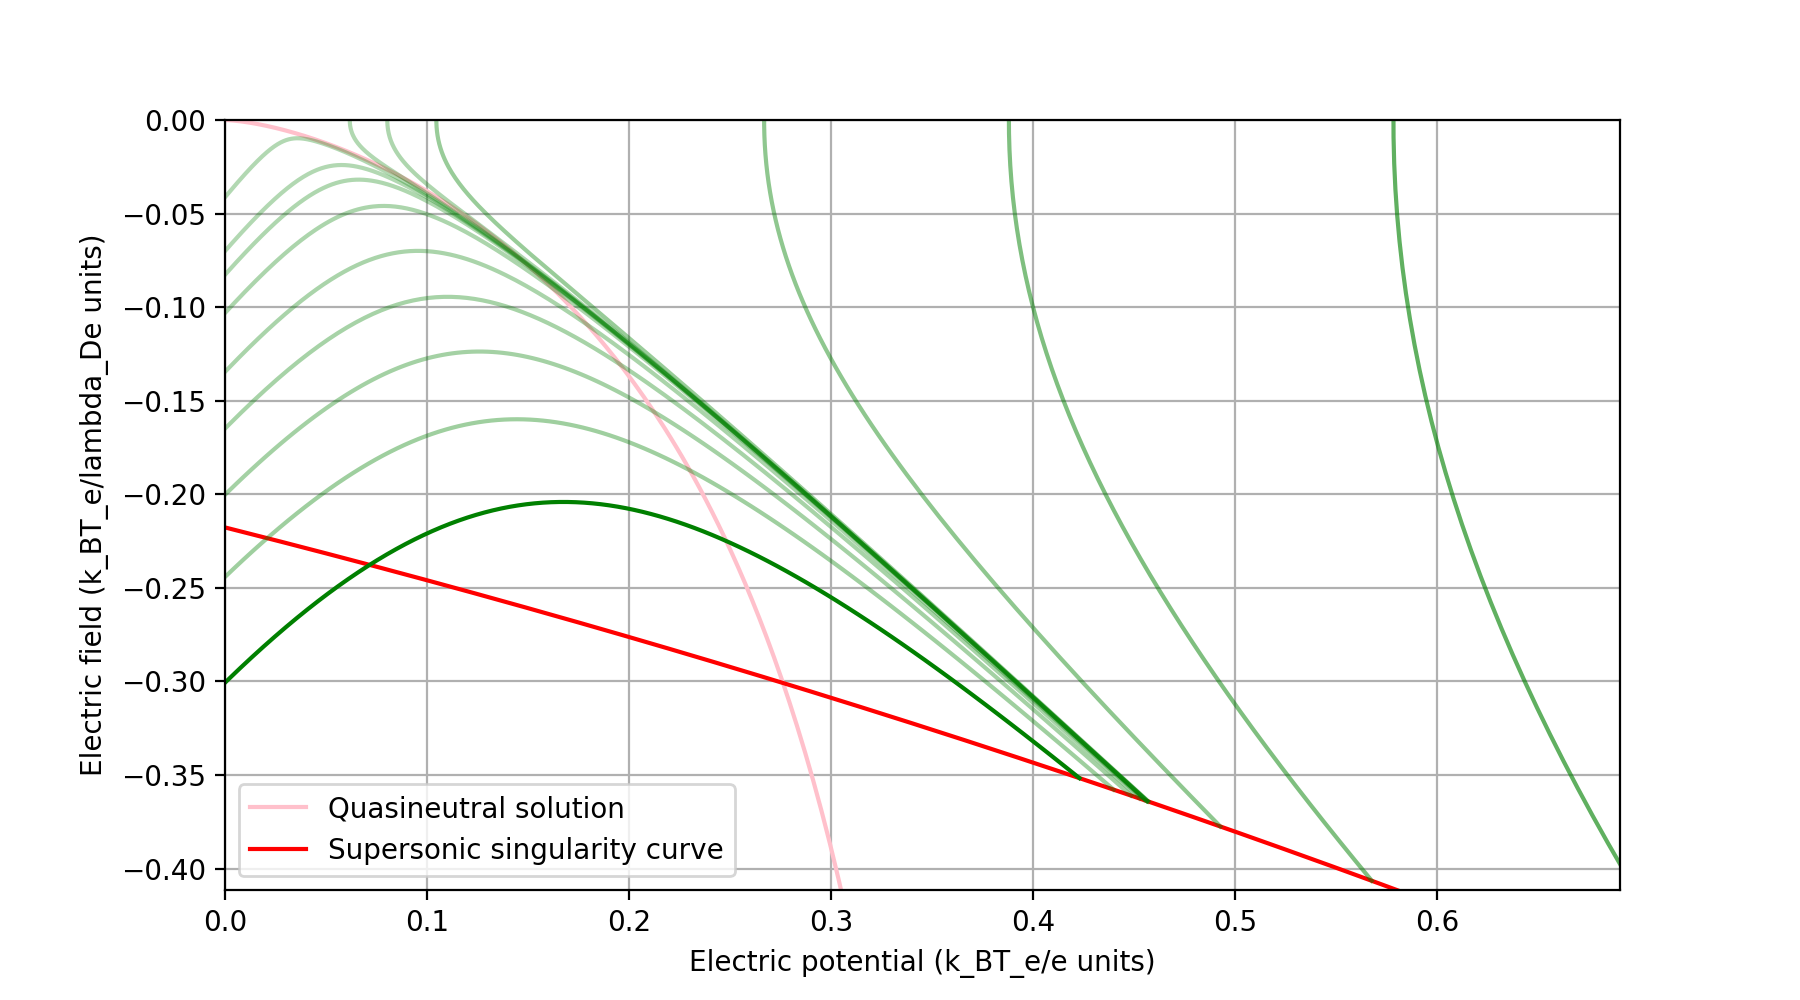

In [1]:
import initialize
import sheath
import functions as f
import ipywidgets.widgets as widgets
import ipywidgets
from ipywidgets import Layout
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook

# Display sliders and options
plasma_radio_buttons = widgets.RadioButtons(
    options=["Argon and electrons", "Neon and electrons", "Helium and electrons", "Oxygen O+ and O-"],
#    layout={'width': 'max-content'}, # If the items' names are long
    description='Plasma type:')
display(plasma_radio_buttons)

bg = initialize.BetaGammaSheath()
bg.x_array = []
bg.y_array = []
bg.z_array = []
bg.N_array = []

Ip_slider = widgets.FloatSlider(value=5, min=1.5, max=100, step=0.1, description='Ip:')
beta_slider = widgets.FloatSlider(value=0.1, min=0.01, max=1.0, step=0.01, description='beta:')
gamma_slider = widgets.FloatSlider(value=0.1, min=0.01, max=1.0, step=0.1, description='gamma_1:', disabled = True)
gamma_button = widgets.ToggleButton(description = "Link to beta", value = True)
alpha0_slider = widgets.FloatSlider(value=0.5, min=0.0, max=10.0, step=0.1, description='alpha0:')

gamma_line = widgets.HBox([gamma_slider, gamma_button])
dl = ipywidgets.jslink((beta_slider, 'value'), (gamma_slider, 'value'))

sliders = widgets.VBox([Ip_slider, beta_slider, gamma_line, alpha0_slider])
display(sliders)

run_button = widgets.Button(description = "Run calculation")
quasi_toogle_button = widgets.ToggleButton(value=True, description='Plot quasineutral')
supersonic_toogle_button = widgets.ToggleButton(value=True, description='Supersonic curve')
add_approx_button = widgets.Button(description='Add approximation', disabled = True)
add_solution_button = widgets.Button(description='Add solution', disabled = True)
run_plot_buttons = widgets.HBox([run_button, add_approx_button, add_solution_button])

display(run_plot_buttons)

info_text = widgets.Text()
display(info_text)

fig1, ax1 = plt.subplots(figsize=(9, 5))  # Create a figure containing a single axes.
ax1.set(xlabel='Distance to the axis (lambda_D units)', ylabel='Electric potential (k_BT_e/e units)')
ax1.grid(b = True)

fig2, ax2 = plt.subplots(figsize=(9, 5))  # Create a figure containing a single axes.
ax2.set(xlabel='Distance to the axis (lambda_D units)', ylabel='Electric potential (k_BT_e/e units)')
ax2.grid(b = True)

fig3, ax3 = plt.subplots(figsize=(9, 5))  # Create a figure containing a single axes.
ax3.set(xlabel='Electric potential (k_BT_e/e units)', ylabel='Electric field (k_BT_e/lambda_De units)')
ax3.grid(b = True)


palette = plt.get_cmap('Set1')
i_palette = 0

def get_y_sing(x0a):
    '''Helper function to get singularity curve'''
    global bg
    [x0, y0, ydot0, xl] = f.getInitFloat(x0a, bg)
    return y0

def get_ydot_sing(x0a):
    '''Helper function to get singularity curve'''
    global bg
    [x0, y0, ydot0, xl] = f.getInitFloat(x0a, bg)
    return ydot0

def gamma_button_toggle(b):
    '''Helper function for gamma toggle button'''
    gamma_slider.disabled = gamma_button.value
    global dl
    dl.unlink()
    if gamma_slider.disabled:
        dl = ipywidgets.jslink((beta_slider, 'value'), (gamma_slider, 'value'))

gamma_button.observe(gamma_button_toggle)

def run_button_clicked(b):
    '''Helper function to pass arguments'''
    info_text.value = "Calculation in progress"
    
    # Pass parameters to bg
    global bg
    global i_palette
    i_palette = 0
    bg.g.Ip = Ip_slider.value
    bg.g.beta = beta_slider.value
    bg.g.gamma = 1/gamma_slider.value
    bg.g.alpha0 = alpha0_slider.value
    bg.p = initialize.Plasma(plasma_radio_buttons.value)
    f.defineI0tuple(bg)
    bg.c.save_approx = True
    sheath.cylindrical(bg) #Note that adimensional plasma sheath solution does not depend on the plasma type
    info_text.value = "Calculation finished"
    
    # Plot according to given options
    ax1.cla()
    ax1.grid(b = True)
    ax1.set(xlabel='Distance to the axis (lambda_D units)', ylabel='Electric potential (k_BT_e/e units)')
    ax2.cla()
    ax2.grid(b = True)
    ax2.set(xlabel='Distance to the axis (lambda_D units)', ylabel='Electric potential (k_BT_e/e units)')
    ax3.cla()
    ax3.set(xlabel='Electric potential (k_BT_e/e units)', ylabel='Electric field (k_BT_e/lambda_De units)')
    ax3.grid(b = True)

    #activate buttons
    add_approx_button.disabled = False
    add_solution_button.disabled = False
    

    # Quasineutral solution
    if quasi_toogle_button.value:
        bg.quasi_x_array = [f.getxCI(y, bg) for y in bg.y_array]
        z_array_temp = [f.getydotCI(bg.quasi_x_array[i], bg.y_array[i], bg) for i in range(len(bg.y_array))]
        bg.quasi_y_array = []
        bg.quasi_z_array = []
        for i in range(len(bg.y_array)):
            if z_array_temp[i] < 0:
                bg.quasi_y_array.append(bg.y_array[i])
                bg.quasi_z_array.append(z_array_temp[i])
#        bg.quasi_y_array = [bg.y_array[i] if z_array_temp[i] < 0 for i in range(len(bg.y_array)) ]
#        bg.quasi_z_array = [z_array_temp[i] for i in range(len(bg.quasi_y_array))]
        ax1.plot(bg.quasi_x_array, bg.y_array, color='pink', label="Quasineutral solution")
        ax2.plot(bg.quasi_x_array, bg.y_array, color='pink', label="Quasineutral solution")
        ax3.plot(bg.quasi_y_array, bg.quasi_z_array, color='pink', label="Quasineutral solution")
    
    # Supersonic singularity curve
    if supersonic_toogle_button.value:
        bg.supersonic_y_array = [get_y_sing(x) for x in bg.x_array]
        bg.supersonic_z_array = [get_ydot_sing(x) for x in bg.x_array]
        ax1.plot(bg.x_array, bg.supersonic_y_array, color='red', label="Supersonic singularity curve")
        ax2.plot(bg.x_array, bg.supersonic_y_array, color='red', label="Supersonic singularity curve")
        ax3.plot(bg.supersonic_y_array, bg.supersonic_z_array, color='red', label="Supersonic singularity curve")
    
    # Plot limits
    ax1.set_xlim(0.4*bg.g.xl, 2*bg.g.xl)
    ax1.set_ylim(0, 2.5*f.getylimit(bg))
    ax1.legend(prop={'size': 10})
    ax2.set_xlim(0, 2*bg.g.xl)
    ax2.set_ylim(0, 40*f.getylimit(bg))
    ax2.legend(prop={'size': 10})
    ax3.set_xlim(0, 2.5*f.getylimit(bg))
    ax3.set_ylim(6*get_ydot_sing(2*bg.g.xl), 0)
    ax3.legend(prop={'size': 10})
    
run_button.on_click(run_button_clicked)

def add_solution_button_clicked(b):
    global bg
    ax1.plot(bg.x_array, bg.y_array, color='blue', label="Potential profile")
    ax1.legend(prop={'size': 10})
    ax2.plot(bg.x_array, bg.y_array, color='blue', label="Potential profile")
    ax2.legend(prop={'size': 10})
    ax3.plot(bg.y_array, bg.z_array, color='blue', label="Potential profile")
    ax3.legend(prop={'size': 10})

add_solution_button.on_click(add_solution_button_clicked)

def add_approx_button_clicked(b):
    global bg
    global i_palette
    i_palette += 1
    if i_palette < len(bg.approx):
        x, y, z = bg.approx[i_palette]
        ax1.plot(x, y, color="green", alpha = (0.25+0.5/i_palette))
        ax2.plot(x, y, color="green", alpha = (0.25+0.5/i_palette))
        ax3.plot(y, z, color="green", alpha = (0.25+0.5/i_palette))
    
add_approx_button.on_click(add_approx_button_clicked)

